# Dependencies

In [1]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
# from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
# from keras.utils import np_utils
# from skimage.transform import resize   # for resizing images
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import random as rnd
from glob import glob
from tqdm import tqdm

datadir = "/home/ephy/Projects/tda_convolve_video/data/"

from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
device='cuda:0'

from scipy.integrate import quad
from scipy.integrate import dblquad
from scipy.integrate import tplquad
from scipy.ndimage import rotate as scipy_rotate
from scipy.ndimage import shift as scipy_shift
from joblib import Parallel, delayed

# Data prep

In [2]:
f = open(datadir+"original/ucfTrainTestlist/trainlist01.txt", "r")
temp = f.read()
videos = temp.split('\n')

# creating a dataframe having video names
train = pd.DataFrame()
train['video_name'] = videos
train = train[:-1]

# open the .txt file which have names of test videos
f = open(datadir+"original/ucfTrainTestlist/testlist01.txt", "r")
temp = f.read()
videos = temp.split('\n')

# creating a dataframe having video names
test = pd.DataFrame()
test['video_name'] = videos
test = test[:-1]

In [3]:
# creating tags
train_video_tag = []
for i in range(train.shape[0]):
    train_video_tag.append(train['video_name'][i].split('/')[0])
    
train['tag'] = train_video_tag

test_video_tag = []
for i in range(test.shape[0]):
    test_video_tag.append(test['video_name'][i].split('/')[0])
    
test['tag'] = test_video_tag

allVids = train.append(test, ignore_index=True)

In [4]:
# Grabbing at ~ 8fps we can get 8. Skipping first frame to get 7

In [7]:
# storing the frames from training videos
for i in tqdm(range(allVids.shape[0])):
    count = 0
    videoFile = allVids['video_name'][i]
    cap = cv2.VideoCapture(datadir + 'original/UCF/'+videoFile.split(' ')[0].split('/')[1])   # capturing the video from the given path
    frameRate = 3 #frame sample rate
    x=1
    i=0
    while(cap.isOpened() and i<7):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        if(frameId!=0):
            if (frameId % math.floor(frameRate) == 0):
                # storing the frames in a new folder named train_1
                filename =datadir+'altered/allUCF101/' + videoFile.split('/')[1].split(' ')[0] +"_frame%d.jpg" % count;count+=1
                cv2.imwrite(filename, frame)
                i+=1
    cap.release()

100%|██████████| 13320/13320 [09:11<00:00, 24.16it/s]


In [11]:
# getting the names of all the images
images = glob(datadir + "altered/allUCF101/*.jpg")

all_image = []
all_vid = []
all_class = []
all_frame = []
for i in tqdm(range(len(images))):
    n = images[i].split('/')[8]
    all_image.append(n)
    all_vid.append('_'.join(n.split('_')[1:4]))
    all_class.append(n.split('_')[1])
    all_frame.append(n.split('_')[4].split('.')[0].split('frame')[1])
# # storing the images and their class in a dataframe
all_data = pd.DataFrame()
all_data['image'] = all_image
all_data['class'] = all_class
all_data['clip'] = all_vid
all_data['frame'] = all_frame

# # converting the dataframe into csv file 
all_data.to_csv(datadir + 'altered/all_data_guide.csv',header=True, index=False)

100%|██████████| 93240/93240 [00:00<00:00, 448064.94it/s]


# Create 3-fold batches

In [4]:
allVids = pd.read_csv(datadir + 'altered/all_data_guide.csv')
allVids = allVids.sort_values(by=['clip', 'frame'])
allVids_dedup = allVids.drop_duplicates(subset=['clip'], keep='first').copy()

In [5]:
# Make an interger based class to make tracking tests more simple
classXwalk = pd.DataFrame({'class': np.unique(allVids_dedup['class'])})
classXwalk['ind'] = np.array(list(range(0,101)))
allVids_dedup['class_int'] = [int(classXwalk['ind'][classXwalk['class']==c]) for c in allVids_dedup['class']]

In [6]:
# # Go through and load videos as 3d volume arrays
# clips = np.unique(allVids['clip'])

# all_image = []
# for i in tqdm(range(len(clips))):
#     stack = []
#     for imageName in allVids[allVids['clip']==clips[i]]['image']:
#         image = cv2.imread(datadir + 'altered/allUCF101/'+imageName)
#         image = Image.fromarray(image , 'RGB')
#         image = image.resize((100 , 100))
#         image = np.array(image)/255
#         image = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
#         stack.append(image)
#     all_image.append(np.array(stack))

# all_image = np.array(all_image)

In [7]:
# np.save('/home/ephy/Projects/tda_convolve_video/data/altered/allVidStack100x100.npy',all_image)
all_image = np.load('/home/ephy/Projects/tda_convolve_video/data/altered/allVidStack100x100.npy', allow_pickle=True)

In [8]:
skf = StratifiedKFold(n_splits=3, random_state=2)
print(skf)

StratifiedKFold(n_splits=3, random_state=2, shuffle=False)


# Load 3x5x5 filters

In [9]:
filters = np.load('/home/ephy/Projects/tda_convolve_video/src/python3/VideoFeatures_355.npy', allow_pickle=True)
flat_filters = filters.reshape(-1, *filters.shape[-3:])

# Implement Network

In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(1, 192, (3,5,5))
        self.conv2 = nn.Conv3d(192, 192, (3,5,5))
        self.conv3 = nn.Conv3d(192, 192, (3,5,5))
        self.conv4 = nn.Conv3d(192, 36, (1,5,5))
        
        x= torch.randn(1,100,100,7).view(-1,1,7,100,100)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 750)
        self.fc2 = nn.Linear(750, 200)
        self.fc3 = nn.Linear(200, 101)
        
        self.batch1 = nn.BatchNorm1d(200)
#         self.drop1 = nn.Dropout(p=0.2)
        self.drop2 = nn.Dropout(p=0.2)
        
        
    def convs(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]*x[0].shape[3]
            
        return x
    
    def forward(self, x):
        # reshape inside of array
        x = self.convs(x)
#         x = self.drop1(x)
        x = x.view(-1, self._to_linear)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.batch1(x)
        x = self.drop2(x)
        x = self.fc3(x)
        return F.softmax(x, dim=1)

In [13]:
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-5)
torch.cuda.memory_allocated()*1e-9

0.785609216

# Define Test

In [14]:
def test(net, X, y, batchSize):
    confusionMatrix = np.zeros([101,101], dtype=np.int8)
    testingSeq = list(range(0,y.shape[0]+1,batchSize))
    testingSeq.append(y.shape[0]+1)
    testingSeq = np.array(testingSeq)
    with torch.no_grad():
        for i in range(len(testingSeq)-1):
            data = X[testingSeq[i]:testingSeq[i+1]].view(-1,1,7,100,100).to(device)
            out = torch.argmax(net(data),axis=1).cpu()
            yt = torch.argmax(y[testingSeq[i]:testingSeq[i+1]],axis=1)
            for pred,label in zip(out,yt):
                confusionMatrix[label][pred] +=1
        del data
        del out        
        return confusionMatrix

## Load data for each fold and run

Test once per epoch until the last epoch and test 5 times in that epoch. Store last 2 models

In [18]:
# results[1]=[]
# lossrec[1]=[]

In [14]:
EPOCHS = 40
# Batch size of 26+1, because normalization requires same batch size and 4472%26=0 (very close to even split) (same logic for training)
testingBatchSize=20
trainingBatchSize=20
results = [[],[],[]]
lossrec = [[],[],[]]

rnd.seed(1)
classMat = np.eye(101,dtype=np.float)
for foldIndex, (train_index, test_index) in enumerate(skf.split(all_image, allVids_dedup['class'])):
    if(foldIndex>0):
        net = Net().to(device)
        optimizer = optim.Adam(net.parameters(), lr=1e-5)
#         torch.cuda.memory_allocated()*1e-9
        #Shuffle does not actually work, so just manually shuffle...
        rnd.shuffle(train_index)
        rnd.shuffle(test_index)
        y_train = allVids_dedup.iloc[train_index]['class_int']
        y_test = allVids_dedup.iloc[test_index]['class_int']
        X_train = all_image[train_index]
        X_test = all_image[test_index]

        y_train = torch.tensor([classMat[c] for c in y_train],dtype=torch.float32)
        y_test = torch.tensor([classMat[c] for c in y_test],dtype=torch.float32)
        X_train = torch.tensor(X_train,dtype=torch.float32)
        X_test =  torch.tensor(X_test,dtype=torch.float32)
        y_train = torch.tensor(np.array(y_train),dtype=torch.float32)
        y_test = torch.tensor(np.array(y_test),dtype=torch.float32)

        trainingSeq = list(range(0,y_train.shape[0],trainingBatchSize))
        trainingSeq.append(y_train.shape[0]+1)
        trainingSeq = np.array(trainingSeq)

        # Grab 5 tests in final epoch (4 + last one run after training loop)
        finalEpochTests = list(range(int((len(trainingSeq)-1)/5),len(trainingSeq)-1,int((len(trainingSeq)-1)/5)))

        for epoch in range(EPOCHS):
            for i in range(len(trainingSeq)-1):
                X=X_train[trainingSeq[i]:trainingSeq[i+1]].view(-1,1,7,100,100)
                X=X.to(device)
                y=y_train[trainingSeq[i]:trainingSeq[i+1]]
                y=y.to(device)
                net.zero_grad()
                output = net(X)
                loss = nn.CrossEntropyLoss()(output, torch.argmax(y, axis=1))
                lossrec[foldIndex].append(float(loss.tolist()))
                loss.backward()
                optimizer.step()
                del loss
                del output
                del X
                del y
                if epoch==(EPOCHS-1) and (i in finalEpochTests):
                    print(foldIndex,'Final Epoch',i)
                    results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
            print('Fold: ', foldIndex, 'Epoch: ',epoch)
            results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
            cm = results[foldIndex][len(results[foldIndex])-1]
            print('Accuracy: ' , sum(np.diag(cm))/np.sum(cm))

        np.save('/home/ephy/Projects/tda_convolve_video/data/models/results/losses_normal355_4layer_fold'+str(foldIndex)+'.npy',lossrec)
        np.save('/home/ephy/Projects/tda_convolve_video/data/models/results/confuseMats_normal355_4layer_fold'+str(foldIndex)+'.npy',results)    

KeyboardInterrupt: 

In [4]:
# Had an accident with not clearing network. Need to merge the first and final fold results of normal to get all folds
l1 = np.load('/home/ephy/Projects/tda_convolve_video/data/models/results/losses_normal355_4layer_fold0.npy', allow_pickle=True)
r1 = np.load('/home/ephy/Projects/tda_convolve_video/data/models/results/confuseMats_normal355_4layer_fold0.npy', allow_pickle=True)
l2 = np.load('/home/ephy/Projects/tda_convolve_video/data/models/results/losses_normal355_4layer_fold2.npy', allow_pickle=True)
r2 = np.load('/home/ephy/Projects/tda_convolve_video/data/models/results/confuseMats_normal355_4layer_fold2.npy', allow_pickle=True)
r2[0] = r1[0]
l2[0] = l1[0]

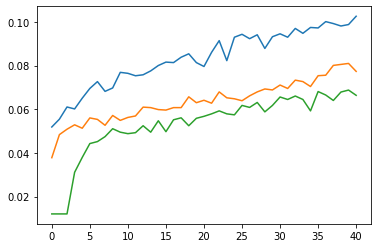

In [5]:
def get_accs(results):
    # Avergae last 5
    end = len(results)-5
    r=[sum(np.diag(cm))/np.sum(cm) for cm in results]
    ret=r[0:end]
    ret.append(np.mean(r[end:len(results)]))
    return(ret)

plt.plot(get_accs(r2[0]))
plt.plot(get_accs(r2[1]))
plt.plot(get_accs(r2[2]))

In [11]:
EPOCHS = 40
# Batch size of 26+1, because normalization requires same batch size and 4472%26=0 (very close to even split) (same logic for training)
testingBatchSize=20
trainingBatchSize=20
results = [[],[],[]]
lossrec = [[],[],[]]

rnd.seed(1)
classMat = np.eye(101,dtype=np.float)
for foldIndex in range(3):
# for foldIndex, (train_index, test_index) in enumerate(skf.split(all_image, allVids_dedup['class'])):
    net = Net().to(device)
    optimizer = optim.Adam(net.parameters(), lr=1e-5)
    # Set filters in 2 layers
    with torch.no_grad():
        for i,weights in enumerate(flat_filters):
            net.conv1.weight[i][0] = torch.nn.Parameter(torch.tensor(weights)).to(device)
            for g,filts in enumerate(net.conv2.weight):
                net.conv2.weight[i][g] = torch.nn.Parameter(torch.tensor(flat_filters[g])).to(device)
        net.conv1.requires_grad=False
        net.conv2.requires_grad=False
    print('Network Reset.')

#     ## Check our work
#     with torch.no_grad():
#         for i,weights in enumerate(flat_filters):
#             print(net.conv2.weight.shape)
#             plt.imshow(net.conv2.weight[i][9][0].cpu(), cmap='gray')
#             plt.show
#             break        
                
    #Shuffle does not actually work, so just manually shuffle...
#     rnd.shuffle(train_index)
#     rnd.shuffle(test_index)
#     y_train = allVids_dedup.iloc[train_index]['class_int']
#     y_test = allVids_dedup.iloc[test_index]['class_int']
#     X_train = all_image[train_index]
#     X_test = all_image[test_index]

    X_train, X_test, y_train, y_test = train_test_split(np.stack(all_image), allVids_dedup['class_int'], shuffle=True, random_state=foldIndex, test_size=0.33, stratify = allVids_dedup['class_int'])


    y_train = torch.tensor([classMat[c] for c in y_train],dtype=torch.float32)
    y_test = torch.tensor([classMat[c] for c in y_test],dtype=torch.float32)
    X_train = torch.tensor(X_train,dtype=torch.float32)
    X_test =  torch.tensor(X_test,dtype=torch.float32)
    y_train = torch.tensor(np.array(y_train),dtype=torch.float32)
    y_test = torch.tensor(np.array(y_test),dtype=torch.float32)

    trainingSeq = list(range(0,y_train.shape[0],trainingBatchSize))
    trainingSeq.append(y_train.shape[0]+1)
    trainingSeq = np.array(trainingSeq)

    # Grab 5 tests in final epoch (4 + last one run after training loop)
    finalEpochTests = list(range(int((len(trainingSeq)-1)/5),len(trainingSeq)-1,int((len(trainingSeq)-1)/5)))

    for epoch in range(EPOCHS):
        for i in range(len(trainingSeq)-1):
            X=X_train[trainingSeq[i]:trainingSeq[i+1]].view(-1,1,7,100,100)
            X=X.to(device)
            y=y_train[trainingSeq[i]:trainingSeq[i+1]]
            y=y.to(device)
            net.zero_grad()
            output = net(X)
            loss = nn.CrossEntropyLoss()(output, torch.argmax(y, axis=1))
            lossrec[foldIndex].append(float(loss.tolist()))
            loss.backward()
            optimizer.step()
            del loss
            del output
            del X
            del y
            if epoch==(EPOCHS-1) and (i in finalEpochTests):
                print(foldIndex,'Final Epoch',i)
                results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
        print('Fold: ', foldIndex, 'Epoch: ',epoch)
        results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
        cm = results[foldIndex][len(results[foldIndex])-1]
        print('Accuracy: ' , np.sum(np.diag(cm))/np.sum(cm))

    np.save('/home/ephy/Projects/tda_convolve_video/data/models/results/losses_2kflayer355_4layer_fold'+str(foldIndex)+'.npy',lossrec)
    np.save('/home/ephy/Projects/tda_convolve_video/data/models/results/confuseMats_2kflayer355_4layer_fold'+str(foldIndex)+'.npy',results)    

Network Reset.
Fold:  0 Epoch:  0
Accuracy:  0.10805277525022748
Fold:  0 Epoch:  1
Accuracy:  0.17743403093721566
Fold:  0 Epoch:  2
Accuracy:  0.22725204731574158
Fold:  0 Epoch:  3
Accuracy:  0.2775250227479527
Fold:  0 Epoch:  4
Accuracy:  0.3061874431301183
Fold:  0 Epoch:  5
Accuracy:  0.336442220200182
Fold:  0 Epoch:  6
Accuracy:  0.3525932666060055
Fold:  0 Epoch:  7
Accuracy:  0.3760236578707916
Fold:  0 Epoch:  8
Accuracy:  0.37898089171974525
Fold:  0 Epoch:  9
Accuracy:  0.3892174704276615
Fold:  0 Epoch:  10
Accuracy:  0.40150136487716104
Fold:  0 Epoch:  11
Accuracy:  0.39308462238398545
Fold:  0 Epoch:  12
Accuracy:  0.4030937215650591
Fold:  0 Epoch:  13
Accuracy:  0.4106005459508644
Fold:  0 Epoch:  14
Accuracy:  0.40741583257506825
Fold:  0 Epoch:  15
Accuracy:  0.40855323020928114
Fold:  0 Epoch:  16
Accuracy:  0.4124203821656051
Fold:  0 Epoch:  17
Accuracy:  0.4153776160145587
Fold:  0 Epoch:  18
Accuracy:  0.41651501364877164
Fold:  0 Epoch:  19
Accuracy:  0.4151

KeyboardInterrupt: 

In [23]:
EPOCHS = 40
# Batch size of 26+1, because normalization requires same batch size and 4472%26=0 (very close to even split) (same logic for training)
testingBatchSize=20
trainingBatchSize=20
results = [[],[],[]]
lossrec = [[],[],[]]

rnd.seed(1)
classMat = np.eye(101,dtype=np.float)
for foldIndex in range(3):
# for foldIndex, (train_index, test_index) in enumerate(skf.split(all_image, allVids_dedup['class'])):
    net = Net().to(device)
    optimizer = optim.Adam(net.parameters(), lr=1e-5)
    # Set filters in 2 layers
    with torch.no_grad():
        for i,weights in enumerate(flat_filters):
            net.conv1.weight[i][0] = torch.nn.Parameter(torch.tensor(weights)).to(device)
#             for g,filts in enumerate(net.conv2.weight):
#                 net.conv2.weight[i][g] = torch.nn.Parameter(torch.tensor(flat_filters[g])).to(device)
        net.conv1.requires_grad=False
#         net.conv2.requires_grad=False
    print('Network Reset.')

#     ## Check our work
#     with torch.no_grad():
#         for i,weights in enumerate(flat_filters):
#             print(net.conv2.weight.shape)
#             plt.imshow(net.conv2.weight[i][9][0].cpu(), cmap='gray')
#             plt.show
#             break        
                
    #Shuffle does not actually work, so just manually shuffle...
#     rnd.shuffle(train_index)
#     rnd.shuffle(test_index)
#     y_train = allVids_dedup.iloc[train_index]['class_int']
#     y_test = allVids_dedup.iloc[test_index]['class_int']
#     X_train = all_image[train_index]
#     X_test = all_image[test_index]

    X_train, X_test, y_train, y_test = train_test_split(np.stack(all_image), allVids_dedup['class_int'],
                                                        shuffle=True, random_state=foldIndex,
                                                        test_size=0.33, stratify = allVids_dedup['class_int'])


    y_train = torch.tensor([classMat[c] for c in y_train],dtype=torch.float32)
    y_test = torch.tensor([classMat[c] for c in y_test],dtype=torch.float32)
    X_train = torch.tensor(X_train,dtype=torch.float32)
    X_test =  torch.tensor(X_test,dtype=torch.float32)
    y_train = torch.tensor(np.array(y_train),dtype=torch.float32)
    y_test = torch.tensor(np.array(y_test),dtype=torch.float32)

    trainingSeq = list(range(0,y_train.shape[0],trainingBatchSize))
    trainingSeq.append(y_train.shape[0]+1)
    trainingSeq = np.array(trainingSeq)

    # Grab 5 tests in final epoch (4 + last one run after training loop)
    finalEpochTests = list(range(int((len(trainingSeq)-1)/5),len(trainingSeq)-1,int((len(trainingSeq)-1)/5)))

    for epoch in range(EPOCHS):
        for i in range(len(trainingSeq)-1):
            X=X_train[trainingSeq[i]:trainingSeq[i+1]].view(-1,1,7,100,100)
            X=X.to(device)
            y=y_train[trainingSeq[i]:trainingSeq[i+1]]
            y=y.to(device)
            net.zero_grad()
            output = net(X)
            loss = nn.CrossEntropyLoss()(output, torch.argmax(y, axis=1))
            lossrec[foldIndex].append(float(loss.tolist()))
            loss.backward()
            optimizer.step()
            del loss
            del output
            del X
            del y
            if epoch==(EPOCHS-1) and (i in finalEpochTests):
                print(foldIndex,'Final Epoch',i)
                results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
        print('Fold: ', foldIndex, 'Epoch: ',epoch)
        results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
        cm = results[foldIndex][len(results[foldIndex])-1]
        print('Accuracy: ' , np.sum(np.diag(cm))/np.sum(cm))

    np.save('/home/ephy/Projects/tda_convolve_video/data/models/results/losses_1kflayer355_4layer_fold'+str(foldIndex)+'.npy',lossrec)
    np.save('/home/ephy/Projects/tda_convolve_video/data/models/results/confuseMats_1kflayer355_4layer_fold'+str(foldIndex)+'.npy',results)    

Network Reset.
Fold:  0 Epoch:  0
Accuracy:  0.0791628753412193
Fold:  0 Epoch:  1
Accuracy:  0.12534121929026387
Fold:  0 Epoch:  2
Accuracy:  0.19654231119199272
Fold:  0 Epoch:  3
Accuracy:  0.26342129208371245
Fold:  0 Epoch:  4
Accuracy:  0.3114194722474977
Fold:  0 Epoch:  5
Accuracy:  0.3614649681528662
Fold:  0 Epoch:  6
Accuracy:  0.4008189262966333
Fold:  0 Epoch:  7
Accuracy:  0.43585077343039125
Fold:  0 Epoch:  8
Accuracy:  0.47202001819836215
Fold:  0 Epoch:  9
Accuracy:  0.49203821656050956
Fold:  0 Epoch:  10
Accuracy:  0.5188808007279345
Fold:  0 Epoch:  11
Accuracy:  0.5238853503184714
Fold:  0 Epoch:  12
Accuracy:  0.5293448589626933
Fold:  0 Epoch:  13
Accuracy:  0.5361692447679709
Fold:  0 Epoch:  14
Accuracy:  0.5407188353048226
Fold:  0 Epoch:  15
Accuracy:  0.543221110100091
Fold:  0 Epoch:  16
Accuracy:  0.5502729754322111
Fold:  0 Epoch:  17
Accuracy:  0.5466333030027297
Fold:  0 Epoch:  18
Accuracy:  0.5543676069153776
Fold:  0 Epoch:  19
Accuracy:  0.5498180

KeyboardInterrupt: 

In [15]:
EPOCHS = 40
# Batch size of 26+1, because normalization requires same batch size and 4472%26=0 (very close to even split) (same logic for training)
testingBatchSize=20
trainingBatchSize=20
results = [[],[],[]]
lossrec = [[],[],[]]

rnd.seed(1)
classMat = np.eye(101,dtype=np.float)
for foldIndex in range(3):
# for foldIndex, (train_index, test_index) in enumerate(skf.split(all_image, allVids_dedup['class'])):
    net = Net().to(device)
    optimizer = optim.Adam(net.parameters(), lr=1e-5)
    # Set filters in 2 layers
    with torch.no_grad():
        for i,weights in enumerate(flat_filters):
            net.conv1.weight[i][0] = torch.nn.Parameter(torch.tensor(weights)).to(device)
#             for g,filts in enumerate(net.conv2.weight):
#                 net.conv2.weight[i][g] = torch.nn.Parameter(torch.tensor(flat_filters[g])).to(device)
        net.conv1.requires_grad=False
#         net.conv2.requires_grad=False
    print('Network Reset.')

#     ## Check our work
#     with torch.no_grad():
#         for i,weights in enumerate(flat_filters):
#             print(net.conv2.weight.shape)
#             plt.imshow(net.conv2.weight[i][9][0].cpu(), cmap='gray')
#             plt.show
#             break        
                
    #Shuffle does not actually work, so just manually shuffle...
#     rnd.shuffle(train_index)
#     rnd.shuffle(test_index)
#     y_train = allVids_dedup.iloc[train_index]['class_int']
#     y_test = allVids_dedup.iloc[test_index]['class_int']
#     X_train = all_image[train_index]
#     X_test = all_image[test_index]

    X_train, X_test, y_train, y_test = train_test_split(np.stack(all_image), allVids_dedup['class_int'],
                                                        shuffle=True, random_state=foldIndex,
                                                        test_size=0.33, stratify = allVids_dedup['class_int'])


    y_train = torch.tensor([classMat[c] for c in y_train],dtype=torch.float32)
    y_test = torch.tensor([classMat[c] for c in y_test],dtype=torch.float32)
    X_train = torch.tensor(X_train,dtype=torch.float32)
    X_test =  torch.tensor(X_test,dtype=torch.float32)
    y_train = torch.tensor(np.array(y_train),dtype=torch.float32)
    y_test = torch.tensor(np.array(y_test),dtype=torch.float32)

    trainingSeq = list(range(0,y_train.shape[0],trainingBatchSize))
    trainingSeq.append(y_train.shape[0]+1)
    trainingSeq = np.array(trainingSeq)

    # Grab 5 tests in final epoch (4 + last one run after training loop)
    finalEpochTests = list(range(int((len(trainingSeq)-1)/5),len(trainingSeq)-1,int((len(trainingSeq)-1)/5)))

    for epoch in range(EPOCHS):
        for i in range(len(trainingSeq)-1):
            X=X_train[trainingSeq[i]:trainingSeq[i+1]].view(-1,1,7,100,100)
            X=X.to(device)
            y=y_train[trainingSeq[i]:trainingSeq[i+1]]
            y=y.to(device)
            net.zero_grad()
            output = net(X)
            loss = nn.CrossEntropyLoss()(output, torch.argmax(y, axis=1))
            lossrec[foldIndex].append(float(loss.tolist()))
            loss.backward()
            optimizer.step()
            del loss
            del output
            del X
            del y
            if epoch==(EPOCHS-1) and (i in finalEpochTests):
                print(foldIndex,'Final Epoch',i)
                results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
        print('Fold: ', foldIndex, 'Epoch: ',epoch)
        results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
        cm = results[foldIndex][len(results[foldIndex])-1]
        print('Accuracy: ' , np.sum(np.diag(cm))/np.sum(cm))

    np.save('/home/ephy/Projects/tda_convolve_video/data/models/results/losses_1kflayer355_4layer_fold'+str(foldIndex)+'.npy',lossrec)
    np.save('/home/ephy/Projects/tda_convolve_video/data/models/results/confuseMats_1kflayer355_4layer_fold'+str(foldIndex)+'.npy',results)    

Network Reset.
Fold:  0 Epoch:  0
Accuracy:  0.07393084622383986
Fold:  0 Epoch:  1
Accuracy:  0.12602365787079162
Fold:  0 Epoch:  2
Accuracy:  0.18471337579617833
Fold:  0 Epoch:  3
Accuracy:  0.25090991810737034
Fold:  0 Epoch:  4
Accuracy:  0.3184713375796178
Fold:  0 Epoch:  5
Accuracy:  0.38034576888080074
Fold:  0 Epoch:  6
Accuracy:  0.4222020018198362
Fold:  0 Epoch:  7
Accuracy:  0.4570063694267516
Fold:  0 Epoch:  8
Accuracy:  0.47929936305732485
Fold:  0 Epoch:  9
Accuracy:  0.49931756141947226
Fold:  0 Epoch:  10
Accuracy:  0.5050045495905369
Fold:  0 Epoch:  11
Accuracy:  0.5209281164695178
Fold:  0 Epoch:  12
Accuracy:  0.5241128298453139
Fold:  0 Epoch:  13
Accuracy:  0.5300272975432211
Fold:  0 Epoch:  14
Accuracy:  0.535031847133758
Fold:  0 Epoch:  15
Accuracy:  0.5325295723384895
Fold:  0 Epoch:  16
Accuracy:  0.5411737943585078
Fold:  0 Epoch:  17
Accuracy:  0.5363967242948134
Fold:  0 Epoch:  18
Accuracy:  0.533894449499545
Fold:  0 Epoch:  19
Accuracy:  0.5400363

KeyboardInterrupt: 

In [ ]:
# Try higher frame rate

In [16]:
EPOCHS = 40
# Batch size of 26+1, because normalization requires same batch size and 4472%26=0 (very close to even split) (same logic for training)
testingBatchSize=20
trainingBatchSize=20
results = [[],[],[]]
lossrec = [[],[],[]]

rnd.seed(1)
classMat = np.eye(101,dtype=np.float)
for foldIndex in range(3):
# for foldIndex, (train_index, test_index) in enumerate(skf.split(all_image, allVids_dedup['class'])):
    net = Net().to(device)
    optimizer = optim.Adam(net.parameters(), lr=1e-5)
    # Set filters in 2 layers
    with torch.no_grad():
        for i,weights in enumerate(flat_filters):
            net.conv1.weight[i][0] = torch.nn.Parameter(torch.tensor(weights)).to(device)
#             for g,filts in enumerate(net.conv2.weight):
#                 net.conv2.weight[i][g] = torch.nn.Parameter(torch.tensor(flat_filters[g])).to(device)
        net.conv1.requires_grad=False
#         net.conv2.requires_grad=False
    print('Network Reset.')

#     ## Check our work
#     with torch.no_grad():
#         for i,weights in enumerate(flat_filters):
#             print(net.conv2.weight.shape)
#             plt.imshow(net.conv2.weight[i][9][0].cpu(), cmap='gray')
#             plt.show
#             break        
                
    #Shuffle does not actually work, so just manually shuffle...
#     rnd.shuffle(train_index)
#     rnd.shuffle(test_index)
#     y_train = allVids_dedup.iloc[train_index]['class_int']
#     y_test = allVids_dedup.iloc[test_index]['class_int']
#     X_train = all_image[train_index]
#     X_test = all_image[test_index]

    X_train, X_test, y_train, y_test = train_test_split(np.stack(all_image), allVids_dedup['class_int'],
                                                        shuffle=True, random_state=foldIndex,
                                                        test_size=0.33, stratify = allVids_dedup['class_int'])


    y_train = torch.tensor([classMat[c] for c in y_train],dtype=torch.float32)
    y_test = torch.tensor([classMat[c] for c in y_test],dtype=torch.float32)
    X_train = torch.tensor(X_train,dtype=torch.float32)
    X_test =  torch.tensor(X_test,dtype=torch.float32)
    y_train = torch.tensor(np.array(y_train),dtype=torch.float32)
    y_test = torch.tensor(np.array(y_test),dtype=torch.float32)

    trainingSeq = list(range(0,y_train.shape[0],trainingBatchSize))
    trainingSeq.append(y_train.shape[0]+1)
    trainingSeq = np.array(trainingSeq)

    # Grab 5 tests in final epoch (4 + last one run after training loop)
    finalEpochTests = list(range(int((len(trainingSeq)-1)/5),len(trainingSeq)-1,int((len(trainingSeq)-1)/5)))

    for epoch in range(EPOCHS):
        if(epoch==13):
            net.conv1.requires_grad=True
        for i in range(len(trainingSeq)-1):
            X=X_train[trainingSeq[i]:trainingSeq[i+1]].view(-1,1,7,100,100)
            X=X.to(device)
            y=y_train[trainingSeq[i]:trainingSeq[i+1]]
            y=y.to(device)
            net.zero_grad()
            output = net(X)
            loss = nn.CrossEntropyLoss()(output, torch.argmax(y, axis=1))
            lossrec[foldIndex].append(float(loss.tolist()))
            loss.backward()
            optimizer.step()
            del loss
            del output
            del X
            del y
            if epoch==(EPOCHS-1) and (i in finalEpochTests):
                print(foldIndex,'Final Epoch',i)
                results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
        print('Fold: ', foldIndex, 'Epoch: ',epoch)
        results[foldIndex].append(test(net, X_test, y_test, testingBatchSize))
        cm = results[foldIndex][len(results[foldIndex])-1]
        print('Accuracy: ' , np.sum(np.diag(cm))/np.sum(cm))

    np.save('/home/ephy/Projects/tda_convolve_video/data/models/results/losses_1kflayer355_4layer_fold'+str(foldIndex)+'.npy',lossrec)
    np.save('/home/ephy/Projects/tda_convolve_video/data/models/results/confuseMats_1kflayer355_4layer_fold'+str(foldIndex)+'.npy',results)    

Network Reset.
Fold:  0 Epoch:  0
Accuracy:  0.08917197452229299


KeyboardInterrupt: 

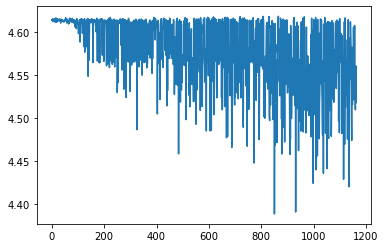

In [21]:
plt.plot(lossrec[0])